In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import  KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler

pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", 60)
pd.set_option("display.width", 1000)

In [149]:
def load_dataset(path_url):
    train_df = pd.read_csv(path_url + "/train.csv")
    test_df = pd.read_csv(path_url + "/test.csv")
    
    test_ids = test_df["Id"]
    train_df = train_df.drop("Id", axis=1)
    test_df = test_df.drop("Id", axis=1)
    
    return train_df, test_df, test_ids

In [150]:
train_df, test_df, test_ids = load_dataset("../data")

In [151]:
def grab_col_names(df, cat_th=10, car_th=20):
    cat_cols = [col for col in df.columns if df[col].dtype == 'O']
    num_but_cat = [col for col in df.columns if df[col].dtype != 'O' and df[col].nunique() < cat_th]
    cat_but_car = [col for col in df.columns if df[col].dtype == 'O' and df[col].nunique() > car_th]
    
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    
    num_cols = [col for col in df.columns if df[col].dtype != 'O' and col != "SalePrice"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    print(f"Categorical columns: {cat_cols}")
    print(f"Numerical columns: {num_cols}")
    print(f"High cardinality columns: {cat_but_car}")
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(train_df)

Categorical columns: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars', 'PoolArea', 'YrSold']
Numerical columns: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageYrBlt', 'Gar

In [152]:
def impute_missing_values(df):
    # Define imputation strategies
    impute_dict = {
        "None": ["PoolQC", "MiscFeature", "Alley", "Fence", "MasVnrType", 
                 "FireplaceQu", "GarageType", "GarageQual", "GarageCond", 
                 "BsmtExposure", "BsmtFinType2", "BsmtQual", "BsmtCond", "BsmtFinType1"],
        0: ["GarageFinish", "BsmtFullBath", "BsmtHalfBath", "BsmtUnfSF",
            "BsmtFinSF1", "BsmtFinSF2", "TotalBsmtSF", "GarageCars", "GarageArea"],
        "mode": ["Electrical", "MSZoning", "Utilities", "Functional", 
                 "Exterior2nd", "Exterior1st", "KitchenQual", "SaleType"],
        "median": ["LotFrontage"]
    }

    # Apply these strategies by iterating dict items. (Ex: value = "None", columns = ["PoolQC", ..., "BsmtFinType1"])
    for value, columns in impute_dict.items():
        if value == "None":
            for col in columns:
                df[col] = df[col].fillna("Not have")
        elif value == 0:
            for col in columns:
                df[col] = df[col].fillna(0)
        elif value == "mode":
            for col in columns:
                df[col] = df[col].fillna(df[col].mode()[0])
        elif value == "median":
            for col in columns:
                df[col] = df[col].fillna(df[col].median())
                
    df.loc[df["GarageType"] == "Not have", "GarageYrBlt"] = 0
    df["GarageYrBlt"] = df["GarageYrBlt"].fillna(df["GarageYrBlt"].median())
    
    df.loc[df["MasVnrType"] == "Not have", "MasVnrArea"] == 0
    df["MasVnrArea"] = df["MasVnrArea"].fillna(df["MasVnrArea"].median())
                
    return df

In [153]:
train_df = impute_missing_values(train_df)
test_df = impute_missing_values(test_df)

In [154]:
def create_features(df):
    df["New_BuildingAge"] = df["YrSold"] - df["YearRemodAdd"]
    df["New_GarageAge"] = df["YrSold"] - df["GarageYrBlt"]
    df["New_TotalBath"] = df["BsmtFullBath"] + df["BsmtHalfBath"] * 0.5 + df["FullBath"] + df["HalfBath"] * 0.5
    df["New_OverallRate"] = df["OverallQual"] * df["OverallCond"]
    df["New_TotalPorchArea"] = df["OpenPorchSF"] + df["EnclosedPorch"] + df["3SsnPorch"] + df["ScreenPorch"]
    df['New_AgeCategory'] = pd.cut(df['New_BuildingAge'], bins=[0, 10, 30, 50, 100, 200], 
                           labels=['0-10', '11-30', '31-50', '51-100', '100+'])
    
    return df

In [242]:
train_df_2 = train_df.copy()
test_df_2 = test_df.copy()

train_df_2 = create_features(train_df_2)
test_df_2 = create_features(test_df_2)

In [243]:
cat_cols, num_cols, cat_but_car = grab_col_names(train_df_2)

Categorical columns: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars', 'PoolArea', 'YrSold', 'New_AgeCategory']
Numerical columns: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'TotRmsAbvGrd', 

In [244]:
ordinal_cols = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", 
                "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC",
                "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond",
                "GarageFinish", "PoolQC", "Fence", "PavedDrive"]

one_hot_cols = [col for col in train_df_2.columns if train_df_2[col].dtype == 'O' and col not in ordinal_cols]
one_hot_cols.append("MSSubClass")
one_hot_cols.append("New_AgeCategory")
num_cols.remove("MSSubClass")

In [245]:
mapping_dict = {
    'PoolQC': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Not have': 0},
    'Fence': {'GdPrv': 4, 'GdWo': 3, 'MnPrv': 2, 'MnWw': 1, 'Not have': 0},
    'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'Not have': 0},
    'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'Not have': 0},
    'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'Not have': 0},
    'KitchenQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'HeatingQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'Not have': 0},
    'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'Not have': 0},
    'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'Not have': 0},
    'ExterQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'ExterCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'Not have': 0},
    'BsmtFinType2': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'Not have': 0},
    'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'Not have': 0},
    'PavedDrive': {'Y': 3, 'N': 2, 'P': 1}
}   

def encode_ordinal_cols(df, ordinal_columns, mapping_dict):
    for col, mapping_values in mapping_dict.items():
        if col in ordinal_columns:
            df[col] = df[col].map(mapping_values)
    
    return df

train_df_2 = encode_ordinal_cols(train_df_2, ordinal_cols, mapping_dict)
test_df_2 = encode_ordinal_cols(test_df_2, ordinal_cols, mapping_dict)

In [246]:
train_df_2.loc[train_df_2["New_BuildingAge"] <0 ]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,New_BuildingAge,New_GarageAge,New_TotalBath,New_OverallRate,New_TotalPorchArea,New_AgeCategory
523,60,RL,130.0,40094,Pave,Not have,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,5,3,PConc,5,3,4,6,2260,1,0,878,3138,GasA,5,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,5,11,Typ,1,4,BuiltIn,2007.0,3.0,3,884,3,3,3,208,406,0,0,0,0,0,0,Not have,0,10,2007,New,Partial,184750,-1,0.0,4.5,50,406,NaN


In [247]:
combined_df = pd.concat([train_df_2, test_df_2], axis=0, ignore_index=True)
combined_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,New_BuildingAge,New_GarageAge,New_TotalBath,New_OverallRate,New_TotalPorchArea,New_AgeCategory
0,60,RL,65.0,8450,Pave,Not have,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,4,3,1,6,706.0,1,0.0,150.0,856.0,GasA,5,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,4,8,Typ,0,0,Attchd,2003.0,2.0,2.0,548.0,3,3,3,0,61,0,0,0,0,0,0,Not have,0,2,2008,WD,Normal,208500.0,5,5.0,3.5,35,61,0-10
1,20,RL,80.0,9600,Pave,Not have,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,Not have,0.0,3,3,CBlock,4,3,4,5,978.0,1,0.0,284.0,1262.0,GasA,5,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,3,6,Typ,1,3,Attchd,1976.0,2.0,2.0,460.0,3,3,3,298,0,0,0,0,0,0,0,Not have,0,5,2007,WD,Normal,181500.0,31,31.0,2.5,48,0,31-50
2,60,RL,68.0,11250,Pave,Not have,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4,3,PConc,4,3,2,6,486.0,1,0.0,434.0,920.0,GasA,5,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,4,6,Typ,1,3,Attchd,2001.0,2.0,2.0,608.0,3,3,3,0,42,0,0,0,0,0,0,Not have,0,9,2008,WD,Normal,223500.0,6,7.0,3.5,35,42,0-10
3,70,RL,60.0,9550,Pave,Not have,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,Not have,0.0,3,3,BrkTil,3,4,1,5,216.0,1,0.0,540.0,756.0,GasA,4,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,4,7,Typ,1,4,Detchd,1998.0,1.0,3.0,642.0,3,3,3,0,35,272,0,0,0,0,0,Not have,0,2,2006,WD,Abnorml,140000.0,36,8.0,2.0,35,307,31-50
4,60,RL,84.0,14260,Pave,Not have,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4,3,PConc,4,3,3,6,655.0,1,0.0,490.0,1145.0,GasA,5,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,4,9,Typ,1,3,Attchd,2000.0,2.0,3.0,836.0,3,3,3,192,84,0,0,0,0,0,0,Not have,0,12,2008,WD,Normal,250000.0,8,8.0,3.5,40,84,0-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,Not have,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,Not have,0.0,3,3,CBlock,3,3,1,1,0.0,1,0.0,546.0,546.0,GasA,4,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,3,5,Typ,0,0,Not have,0.0,NaN,0.0,0.0,0,0,3,0,0,0,0,0,0,0,0,Not have,0,6,2006,WD,Normal,NaN,36,2006.0,1.5,28,0,31-50
2915,160,RM,21.0,1894,Pave,Not have,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,Not have,0.0,3,3,CBlock,3,3,1,3,252.0,1,0.0,294.0,546.0,GasA,3,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,3,6,Typ,0,0,CarPort,1970.0,1.0,1.0,286.0,3,3,3,0,24,0,0,0,0,0,0,Not have,0,4,2006,WD,Abnorml,NaN,36,36.0,1.5,20,24,31-50
2916,20,RL,160.0,20000,Pave,Not have,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,Not have,0.0,3,3,CBlock,3,3,1,5,1224.0,1,0.0,0.0,1224.0,GasA,5,Y,S

In [248]:
def one_hot_encoder(df, categorical_cols, drop_first=False):
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=drop_first)
    return df

combined_df = one_hot_encoder(combined_df, one_hot_cols, True)

In [251]:
combined_df.iloc[:1461]["SalePrice"].tail()

1456    210000.0
1457    266500.0
1458    142125.0
1459    147500.0
1460         NaN
Name: SalePrice, dtype: float64

In [252]:
train_df_2, test_df_2 = combined_df.iloc[:1460], combined_df.iloc[1460:]
train_df_2.shape, test_df_2.shape

((1460, 234), (1459, 234))

## Model

In [253]:
X = train_df_2.drop("SalePrice", axis=1)
y = train_df_2["SalePrice"]

In [254]:
xgb_model_0 = XGBRegressor()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb_model_0, X, y, cv=kf)
print("Mean CV Score:", scores.mean())

Mean CV Score: 0.8277792517519197


In [210]:
X_test = test_df_2.copy()
X_test = X_test.drop("SalePrice", axis=1)

xgb_model_0.fit(X, y)

# Make predictions on test data
y_pred = xgb_model_0.predict(X_test)

# Create submission file
submission_df = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': y_pred 
})

# Save submission file
submission_df.to_csv('../data/submission.csv', index=False)

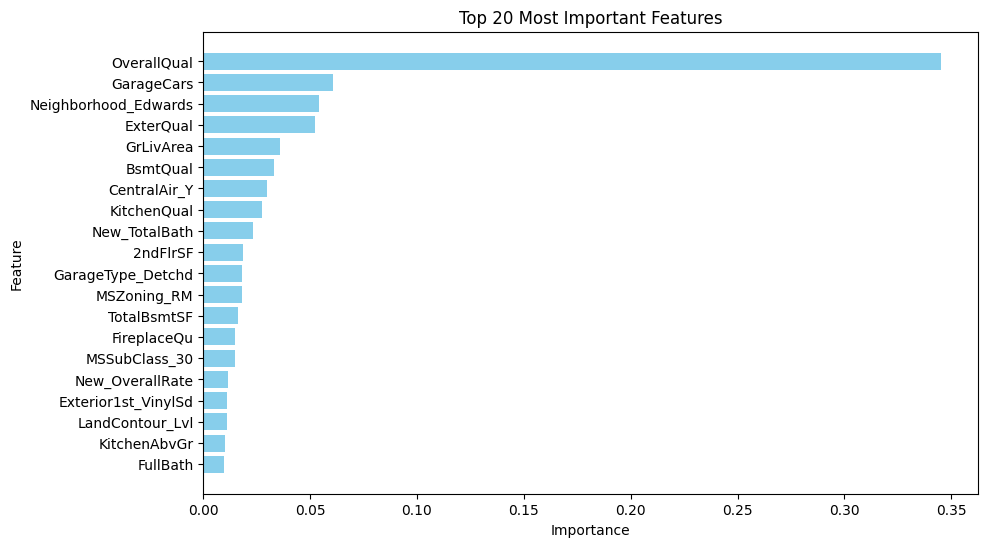

In [ ]:
importance = xgb_model_0.feature_importances_

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

top_features = feature_importance.sort_values(by="Importance", ascending=False).head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 20 Most Important Features")
plt.gca().invert_yaxis()  # Flip to show the most important feature on top
plt.show()